# Dano's pyRiemann  notebook

In this notebook, I will try and use pyRiemann and data from all subjects to predict cognitive performance from EEG data in Neurodoro

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

Steps

1. Concat all raw datasets together
2. Use Knearest Neighbors in pipeline

In [108]:
# Here are the good raw datasets

monica = pd.read_csv("../muse-data/MonicaGRawEEG0.csv", header=0, index_col=False)
monica = monica[:38000]

dano1 = pd.read_csv("../muse-data/DanoMondayRawEEG0.csv", header=0, index_col=False)
dano2 = pd.read_csv("../muse-data/Dano-08-11-RawEEG0.csv", header=0, index_col=False)
dano3 = pd.read_csv("../muse-data/Dano-08-11-RawEEG3.csv", header=0, index_col=False)




In [120]:
# Add them all together

data = pd.concat([monica,dano1,dano2,dano3])
data = data[data.Performance > -200]
data = data.drop('Timestamp (ms)', axis = 1)
data.reset_index(drop=True)


,Difficulty,Performance,Channel 1,Channel 2,Channel 3,Channel 4
0,0,0,487.232990,569.475538,575.156767,479.387484
1,0,0,456.075779,522.673674,514.112317,409.617701
2,0,0,835.957052,962.667141,952.051364,778.598121
3,0,0,912.851281,1057.227213,1054.159345,870.660624
4,0,0,706.852916,802.325481,789.910665,659.249648
5,0,0,617.613835,711.468400,711.485316,585.479840
6,0,0,717.877179,818.589342,829.912818,704.245968
7,0,0,776.271770,870.050917,878.268466,749.776457
8,0,0,759.758949,852.210667,866.282786,709.933029
9,0,0,775.530536,856.145420,876.778855,761.307720


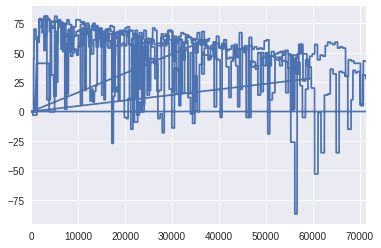

In [122]:
%matplotlib inline
data.Performance.plot()

In [123]:
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values[:,-5:].T
data

# convert in Volts (from uVolts)
data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=5, n_times=275552
    Range : 0 ... 275551 =      0.000 ...  1076.371 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-124-39b392d59ea0>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


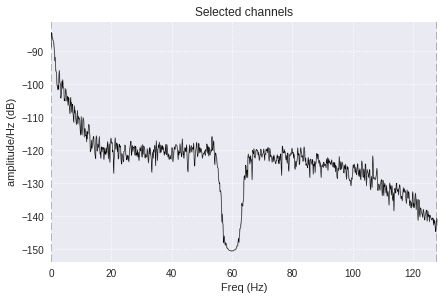

In [124]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[1]);


In [125]:
raw.filter(2, 50, method='iir')

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 5 x 275552 (1076.4 sec), ~10.5 MB, data loaded>

## Epochs

In [126]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=4, preload=True)

epochs

2152 matching events found
0 projection items activated
Loading data for 2152 events and 1025 original time points ...
7 bad epochs dropped


<Epochs  |  n_events : 2145 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~83.9 MB, data loaded>

In [127]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(2145, 4, 1025) (2145, 1)


In [128]:
# Let's transform our data into a covariance matrix and a tangentspace
covs = Covariances().fit_transform(X)
tans = TangentSpace().fit_transform(covs)
potato = Potato().fit_transform(covs)

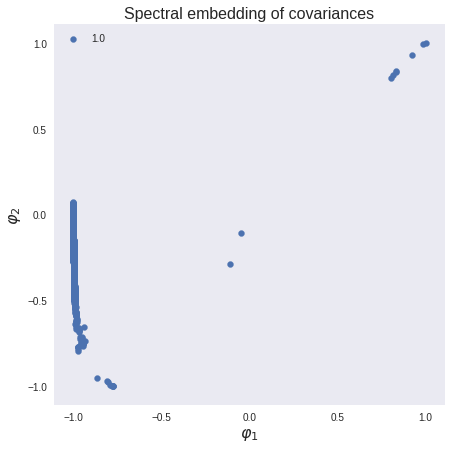

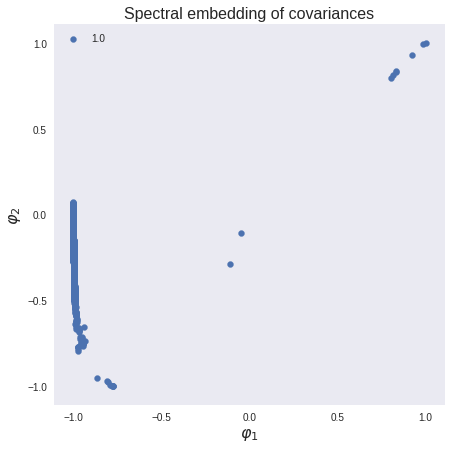

In [129]:
# Now that we have our data setup for sklearn in X and y, let's visualize it

plot_embedding(covs[::])

In [148]:

clf = make_pipeline(Covariances(), TangentSpace(), KNeighborsRegressor(n_neighbors=23, p=1, weights="distance"))


clf.fit(X, y)

Pipeline(steps=[('covariances', Covariances(estimator='scm')), ('tangentspace', TangentSpace(metric='riemann', tsupdate=False)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=23, p=1,
          weights='distance'))])

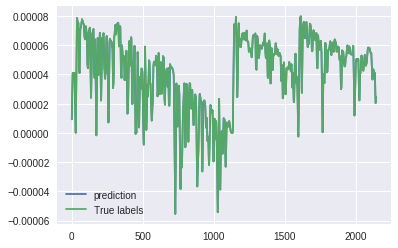

In [149]:
pr = clf.predict(X)
plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

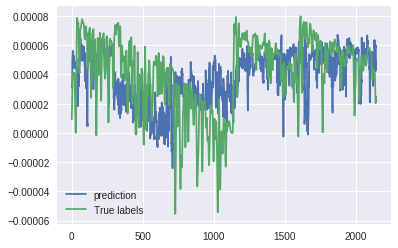

In [150]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=6)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

In [151]:
print(sk.metrics.mean_squared_error(y, pr))

6.20579243548e-10


Mean Squared error with linear regressor = 6.76041083386e-10
Mean Squared error with KNeighboursRegressor = 6.20579243548e-10
